In [3]:
import warnings
warnings.simplefilter('ignore')


import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ta
from ta.trend import EMAIndicator 

np.random.seed(1) #to fix the results
rs=2


In [4]:
#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy()


#buld the best window features after the exploratory data analysis:
for n in list(range(1,15)):
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
    

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

#df = np.log(df+1)

In [6]:
"""
INSTRUCTIONS
Using the example of the 2 label target as inspiration
construct a 3 label target called retFut1_categ
where the returns are binned into 3 equal quartiles: 
0.34 and below, getting label -1
0.34 to 0.66,  getting label 0
0.66 and above, getting label 1
"""
#transform the target
#you have the option of a 3 label target or a 2 label target

#2 label target
#df['retFut1_categ']=0
#df.loc[df['retFut1']>df['retFut1'][:10000].quantile(q=0.51),'retFut1_categ']=1

#3 label target gets better results
#####
#####
#####
df['retFut1_categ'] = 0
df.loc[df['retFut1'] > df['retFut1'].quantile(q=0.66), 'retFut1_categ'] = 1
df.loc[df['retFut1'] < df['retFut1'].quantile(q=0.34), 'retFut1_categ'] = -1

df.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>,ret1,ret2,ret3,...,ret9,ret10,ret11,ret12,ret13,ret14,hour,day,retFut1,retFut1_categ
<DATETIME>,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00,1.4463,1.4465,1.4450,1.4451,32,0,50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.001245,-1
2000-01-03 03:00:00,1.4445,1.4459,1.4445,1.4451,54,0,50,-0.001245,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0.000485,1
2000-01-03 06:00:00,1.4452,1.4485,1.4450,1.4466,171,0,50,0.000485,-0.000761,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6,0,0.001038,1
2000-01-03 09:00:00,1.4467,1.4475,1.4438,1.4440,489,0,50,0.001038,0.001523,0.000277,...,NaN,NaN,NaN,NaN,NaN,NaN,9,0,-0.001590,-1
2000-01-03 12:00:00,1.4444,1.4457,1.4407,1.4415,608,0,50,-0.001590,-0.000554,-0.000069,...,NaN,NaN,NaN,NaN,NaN,NaN,12,0,-0.001800,-1


In [7]:
"""
INSTRUCTIONS
Use df.groupby to find out if the target labels (0, 1, and -1) are balanced
if they are not, you need to choose an appropriate metric e.g. phik or f1_macro or use 
if you want to use accuracy, you need to use class_weight='balanced' in the estimator
to make the importance of the lables match their frequency
"""

#always check to see that the labels occur in equal numbers
# dfgroups = ##### #if they do not, use "balanced" parameter in the estimator (see below)
dfgroups = df.groupby('retFut1_categ').size()
dfgroups


retFut1_categ
-1    15204
 0    14308
 1    15204
dtype: int64

In [8]:
#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#Build some Ta-lib features, with n=10, to be optiized in the pipeline
n=10
# df['RSI']=ta.RSI(np.array(df['<CLOSE>']), timeperiod=n)
# df['SMA'] = df['<CLOSE>'].rolling(window=n).mean()
# df['Corr']= df['<CLOSE>'].rolling(window=n).corr(df['SMA'])
# df['SAR']=ta.SAR(np.array(df['<HIGH>']),np.array(df['<LOW>']), 0.2,0.2)
# df['ADX']=ta.ADX(np.array(df['<HIGH>']),np.array(df['<LOW>']), np.array(df['<OPEN>']), timeperiod =n)
# df['OO']= df['<OPEN>']-df['<OPEN>'].shift(1)
# df['OC']= df['<OPEN>']-df['<CLOSE>']
df['RSI']= ta.momentum.RSIIndicator(close=df['<CLOSE>'], window=n).rsi()

df['SMA'] = df['<CLOSE>'].rolling(window=n).mean()
df['Corr']= df['<CLOSE>'].rolling(window=n).corr(df['SMA'])

# df['SAR']=ta.SAR(np.array(df['<HIGH>']),np.array(df['<LOW>']), 0.2,0.2)
df['SAR']=ta.trend.PSARIndicator(high=df['<HIGH>'], 
                                    low=df['<LOW>'],
                                    close=df['<CLOSE>'],
                                    step=0.2, 
                                    max_step=0.2).psar()

# df['ADX']=ta.ADX(np.array(df['<HIGH>']),np.array(df['<LOW>']), np.array(df['<OPEN>']), timeperiod =n)
df['ADX']=ta.trend.ADXIndicator(high=df['<HIGH>'], 
                                low=df['<LOW>'], 
                                close=df['<CLOSE>'], 
                                window=n).adx()


df['OO']= df['<OPEN>']-df['<OPEN>'].shift(1)
df['OC']= df['<OPEN>']-df['<CLOSE>']
df.fillna(0, inplace=True)


In [9]:
#select the features (by dropping)
cols_to_drop = ["<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]


In [10]:
#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import matthews_corrcoef
from sklearn.svm import LinearSVC
import detrendPrice 
import WhiteRealityCheckFor1 


def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    #print(phi_k_corr)
    print(phi_k_p_val)
    return phi_k_corr

#ph_k is supposed to be better than phi, provided here for comparison
def phi(y_true, y_pred):
    mcc = matthews_corrcoef(y_true,y_pred) #a.k.a. phi
    print (mcc)
    return mcc



In [67]:
"""
INSTRUCTIONS
add two lines code that calculate
x['RSI'] and x['ADX'] using the incoming timeperiod parameter
that is selected from a parameter grid
use previous definition above of RSI and ADX

make sure  RSI_ADX_optimizer is working properly
the way it is programmed, it assumes that x is coming in as a dataframe.
(ASIDE: If it is not coming in as a dataframe (if you did not order it first in the pipeline) then 
you need to use column indexes instead of column names (like <CLOSE>)).
you can check if RSI_ADX_optimizer is running properly as follows:
first set None to 10 in the function declaration i.e.:
def RSI_ADX_optimizer(x, timeperiod=None) ==> def RSI_ADX_optimizer(x, timeperiod=10)
then get a look at the checkme variable as follows:
checkme = Pipeline(steps=[('t',talib),('preprocessor', preprocessor)]).fit_transform(x_train)
or
checkme = Pipeline(steps=[('t',talib)]).fit_transform(x_train)
"""

#for optimizing the timeperiod of RSI and ADX
#x is a dataframe because this happens first in the pipeline


# def RSI_ADX_optimizer(x, timeperiod=None):
#     x['RSI'] = #####
#     x['ADX'] = #####
#     return x

def RSI_ADX_optimizer(x, timeperiod=10):
    # x[4] =ta.RSI(x[3], timeperiod=timeperiod) 
    # x[5] = ta.ADX(x[1],x[2], x[0], timeperiod=timeperiod)
    # x[0]x[1]x[2]x[3]x[4]x[5] are '<OPEN>','<HIGH>','<LOW>','<CLOSE>','RSI', 'ADX' 

    # modified; use df instead of numpy arrays
    x = x.copy()  # don't modify original

    x['RSI'] = ta.momentum.RSIIndicator(close=x['<CLOSE>'], window=timeperiod).rsi()
    x['ADX'] = ta.trend.ADXIndicator(
        high=x['<HIGH>'],
        low=x['<LOW>'],
        close=x['<CLOSE>'],
        window=timeperiod
    ).adx()

    x['RSI'] = x['RSI'].fillna(0)
    x['ADX'] = x['ADX'].fillna(0)

    return x

In [72]:
#myscorer= "accuracy"  #same as None; 
#myscorer = make_scorer(phi_k, greater_is_better=True)
myscorer="f1_macro"
#my_scorer="f1_weighted" 
#myscorer = make_scorer(phi, greater_is_better=True) 

"""
INSTRUCTIONS
select the correct split, see comments above
"""

#when using smoother, use TimesSeriesSplit
split = 5 
split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window
split = TimeSeriesSplit(n_splits=5)


"""
INSTRUCTIONS
Use a FunctionTransformer 
to wrap RSI_ADX_optimizer into an object that has the fit_transform method.
For guidance see: https://archive.is/hsurj
"""
# rsiadx = #####
rsiadx = FunctionTransformer(RSI_ADX_optimizer, kw_args={'timeperiod': 10}, validate=False)

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

numeric_features_no = []
for i in numeric_features_ix:
    numeric_features_no.append(x_train.columns.get_loc(i))
categorical_features_no = []
for i in categorical_features_ix:
    categorical_features_no.append(x_train.columns.get_loc(i))
col_no = []
for c in list(['<OPEN>','<HIGH>','<LOW>','<CLOSE>','RSI', 'ADX']):
    col_no.append(x_train.columns.get_loc(c))

#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_no),
        ('cat', categorical_sub_pipeline, categorical_features_no)], remainder='passthrough')

"""
INSTRUCTIONS
Define a ColumnTransformer that uses the rsiadx tansformer
For guidance see: https://archive.is/hpwzH
"""

talib = ColumnTransformer(
    transformers=[
        ('rsiadx', rsiadx, col_no)], remainder='passthrough')

"""
INSTRUCTIONS
select the correct SVC after checking if the target labels are balanced
"""
svc = LinearSVC(class_weight='balanced') #to balance the label categories, if they do not occur in equal numbers
svc = LinearSVC() 

"""
INSTRUCTIONS
Define a appropriate pipeline
For guidance see: https://archive.is/hpwzH
"""

# pipe = #####
pipe = Pipeline(steps=[
    ('talib', talib),
    ('preprocessor', preprocessor),
    ('svc', svc)
])

c_rs = np.linspace(0.001, 1, num=8, endpoint=True) #1 default
c_rs = np.logspace(3, -4, num=50, endpoint = True)

"""
INSTRUCTIONS
Define a parameter grid for the timeperiod (try 5, 10 and 15)
for guidance see: https://archive.is/RPs90
"""
# timeperiod_rs = #####
timeperiod_rs = [{'timeperiod': 5},{'timeperiod': 10},{'timeperiod': 15}]


<OPEN>     float64
<HIGH>     float64
<LOW>      float64
<CLOSE>    float64
ret1       float64
ret2       float64
ret3       float64
ret4       float64
ret5       float64
ret6       float64
ret7       float64
ret8       float64
ret9       float64
ret10      float64
ret11      float64
ret12      float64
ret13      float64
ret14      float64
hour         int32
day          int32
RSI        float64
SMA        float64
Corr       float64
SAR        float64
ADX        float64
OO         float64
OC         float64
dtype: object


In [73]:
# param_grid = {'t__rsiadx__kw_args':  timeperiod_rs,'svc__C': c_rs}
param_grid = {'talib__rsiadx__kw_args':  timeperiod_rs,'svc__C': c_rs}

grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_svc.csv")

Best parameters : {'talib__rsiadx__kw_args': {'timeperiod': 5}, 'svc__C': 517.9474679231213}
Best cross-validation score : 37.70


In-sample: CAGR=0.0123881 Sharpe ratio=0.495263 maxDD=-0.082504 maxDDD=2605 Calmar ratio=0.150152



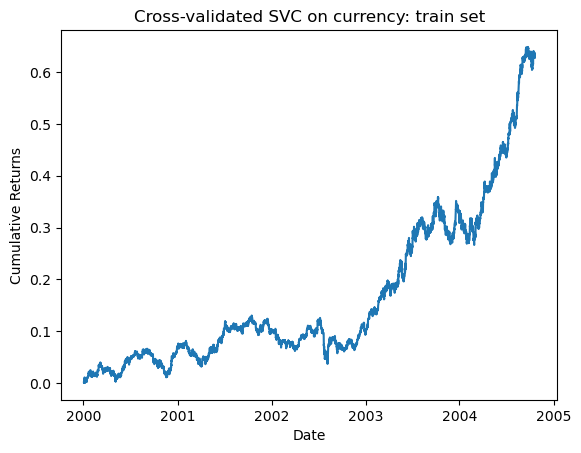

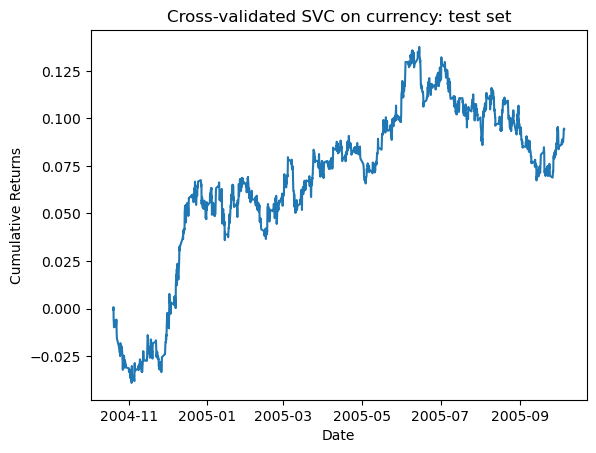

In [74]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS


dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated SVC on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated SVC on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

Out-of-sample: CAGR=0.0114202 Sharpe ratio=0.365851 maxDD=-0.06172 maxDDD=644 Calmar ratio=0.185032  phi_k_corr=0.306021 phi_k_p_val=3.5039e-09  accuracy_score=0.402



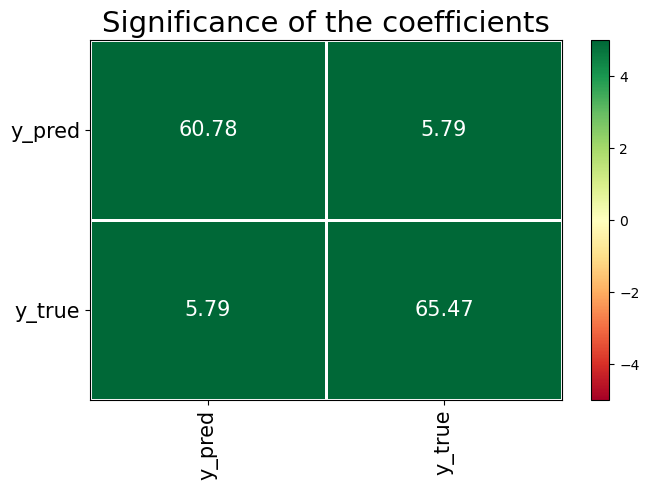

In [75]:
#metrics
accscore = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accscore))


In [76]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
sns.histplot(residuals, kde=True, stat='density', ax=axes[0], label='Residuals', color='blue')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
plt.close("all")

#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])


Ljung-Box test p-value 9.372473074803219e-48


average return 0.000610
[-0.00283418  0.0028561 ]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.33540000000000003


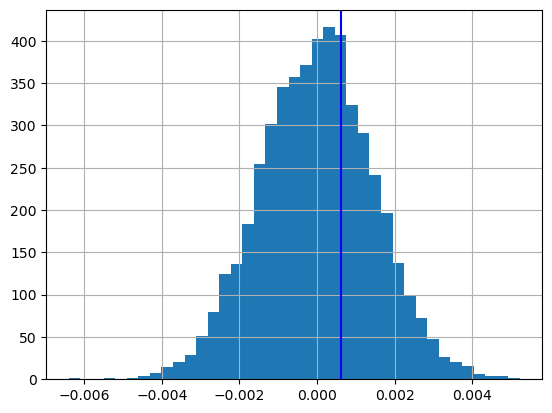

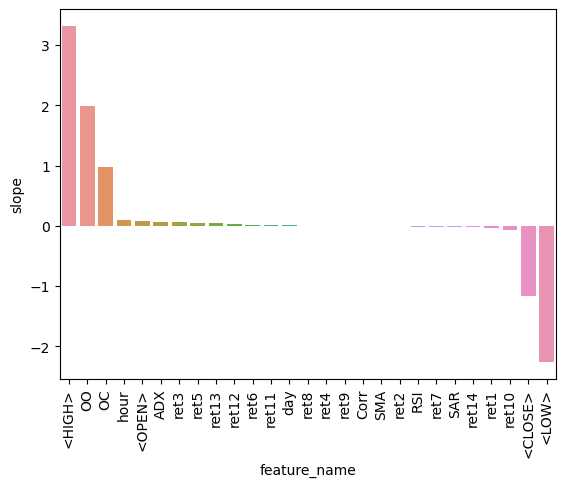

In [77]:
#white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()

importance = pd.DataFrame(zip(best_model[2].coef_.ravel().tolist(), x_train.columns.values.tolist()))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)

#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))



In [78]:
"""
INSTRUCTIONS
make sure you understand how to obtain the continous predictors of a classifier
for use later on in Alphalens.
"""

from sklearn.calibration import CalibratedClassifierCV

model_svc = LinearSVC(C=0.001)
model = CalibratedClassifierCV(model_svc) 

model.fit(x_train, y_train)
pred_class = model.predict(x_test)
pred_proba = model.predict_proba(x_test)
dfpred = pd.DataFrame(pred_proba, columns=["downs","statics","ups"])

dfpred["continuous_predictions"] = np.where(np.logical_and(dfpred["ups"]>dfpred["downs"],dfpred["ups"]>dfpred["statics"]), dfpred["ups"]+1, dfpred["statics"])
dfpred["continuous_predictions"] = np.where(np.logical_and(dfpred["downs"]>dfpred["ups"],dfpred["downs"]>dfpred["statics"]), dfpred["downs"]*-1, dfpred["continuous_predictions"])
